In [1]:
from experiments.seathru.seathru import run_pipeline, find_backscatter_estimation_points, find_backscatter_values
from skimage.restoration import denoise_tv_chambolle, estimate_sigma
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

from pathlib import Path

In [2]:
# name = "T_S04856"
name = "T_S04912"
# name = "T_S04923"

png_file = Path(f"../../data/seathru/D3/D3/linearPNG/{name}.png")
tif_file = Path(f"../../data/seathru/D3/D3/depth/depth{name}.tif")

In [3]:
class Args:
    def __init__(self, f, l, p, min_depth, max_depth, spread_data_fraction):
        self.f = f
        self.l = l
        self.p = p
        self.min_depth = min_depth
        self.max_depth = max_depth
        self.spread_data_fraction = spread_data_fraction

    def __iter__(self):
        return self.__dict__.__iter__()


In [4]:

def img2double(img: np.ndarray, max_value: float) -> np.ndarray:
    img_double = img.astype(np.float64)

    return img_double / max_value

class ColorCorrection:
    def __init__(
        self,
        f=2.0,
        l=0.5,
        p=0.1,
        min_depth=0.0,
        max_depth: float = None,
        spread_data_fraction=0.05,
    ):
        self.__f = f
        self.__l = l
        self.__p = p
        self.__min_depth = min_depth
        self.__max_depth = max_depth
        self.__spread_data_fraction = spread_data_fraction

    def __img2double(self, img: np.ndarray, max_value: float) -> np.ndarray:
        img_double = img.astype(np.float64)

        return img_double / max_value

    def __double2img(
        self, double: np.ndarray, max_value: float, dtype: np.dtype
    ) -> np.ndarray:
        return (double * max_value).astype(dtype)

    def correct_color(self, img: np.ndarray, depth_map: np.ndarray) -> np.ndarray:
        max_value = float(img.max())

        args = Args(
            self.__f,
            self.__l,
            self.__p,
            self.__min_depth,
            self.__max_depth or depth_map.max(),
            self.__spread_data_fraction,
        )
        recovered = run_pipeline(
            self.__img2double(img, max_value), depth_map, args
        )
        sigma_est = (
            estimate_sigma(recovered, channel_axis=2, average_sigmas=True) / 10.0
        )
        recovered = denoise_tv_chambolle(recovered, sigma_est, channel_axis=2)

        return self.__double2img(recovered, max_value, img.dtype)

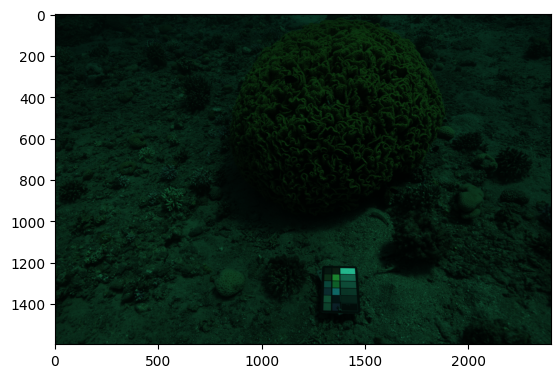

In [5]:
png_image = Image.open(png_file)
png = np.array(png_image)

height, width, _ = png.shape

plt.imshow(png)

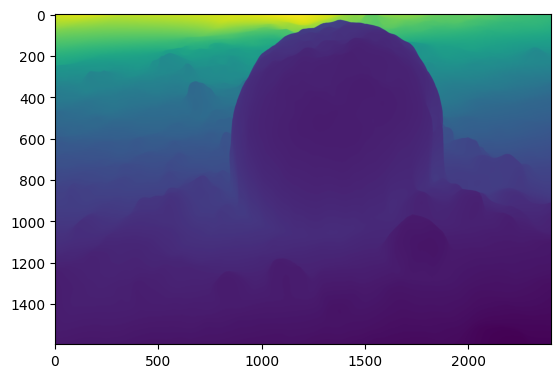

In [6]:
tif_image = Image.open(tif_file)
tif = np.array(tif_image)
tif = cv2.resize(tif, (width, height),  interpolation = cv2.INTER_NEAREST)

plt.imshow(tif)

In [7]:
png.shape, tif.shape

((1596, 2400, 3), (1596, 2400))

Estimating backscatter...
Finding backscatter coefficients...
Constructing neighborhood map...
Refining neighborhood map...
Estimating illumination...


/home/chris/Repos/school/e4e/fishsense/pyAqua3dDev/experiments/seathru/seathru.py:404: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  refined_nmap = closing(refined_nmap, square(radius))


Estimating wideband attenuation...
Found best loss 0.6915058382672541
Found best loss 0.7636595356974537
Found best loss 0.4418016111519236
Reconstructing image...


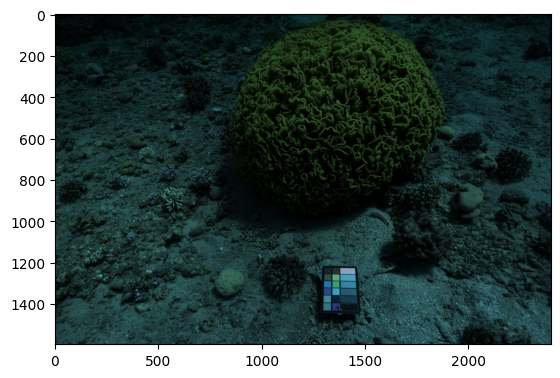

In [8]:
color_correction = ColorCorrection()
corrected = color_correction.correct_color(png, tif)

plt.imshow(corrected)

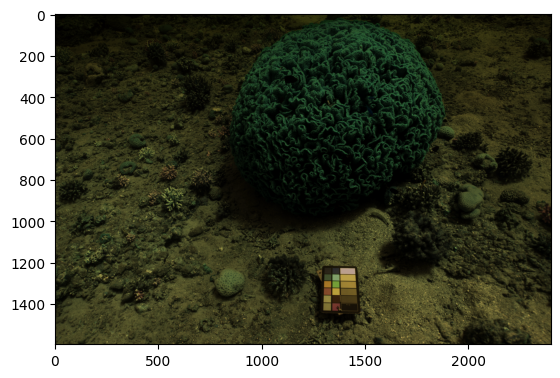

In [9]:
plt.imshow(cv2.cvtColor(corrected, cv2.COLOR_BGR2RGB))

Estimating backscatter...
Finding backscatter coefficients...
Constructing neighborhood map...
Refining neighborhood map...
Estimating illumination...
Estimating wideband attenuation...
Found best loss 0.398384830902427
Found best loss 0.9985373282052468
Found best loss 0.8795197384647206
Reconstructing image...


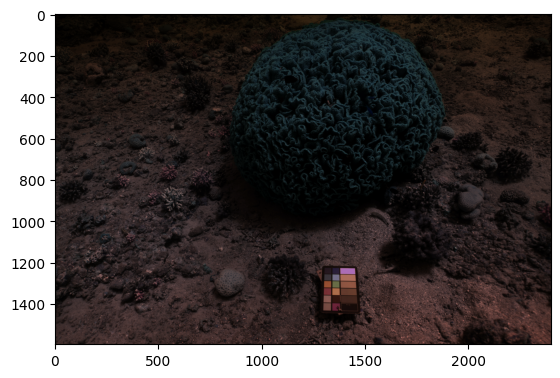

In [10]:
corrected = color_correction.correct_color(cv2.cvtColor(png, cv2.COLOR_RGB2BGR), tif)

plt.imshow(corrected)

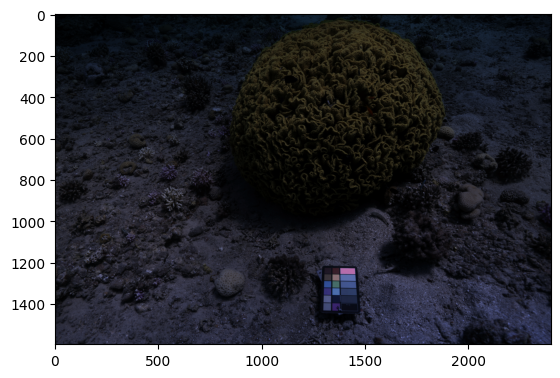

In [11]:
plt.imshow(cv2.cvtColor(corrected, cv2.COLOR_BGR2RGB))

In [12]:
img = img2double(png, png.max())

print("Estimating backscatter...", flush=True)
ptsR, ptsG, ptsB = find_backscatter_estimation_points(
    img, tif, fraction=0.01, min_depth_percent=0
)

print("Finding backscatter coefficients...", flush=True)
Br, coefsR = find_backscatter_values(ptsR, tif, restarts=25)
Bg, coefsG = find_backscatter_values(ptsG, tif, restarts=25)
Bb, coefsB = find_backscatter_values(ptsB, tif, restarts=25)

backscatter = np.zeros_like(img)
backscatter[:, :, 0] = Br
backscatter[:, :, 1] = Bg
backscatter[:, :, 2] = Bb

Estimating backscatter...


Finding backscatter coefficients...


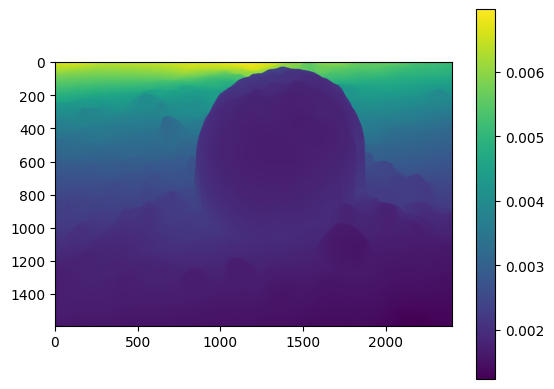

In [13]:
plt.imshow(Br)
plt.colorbar()

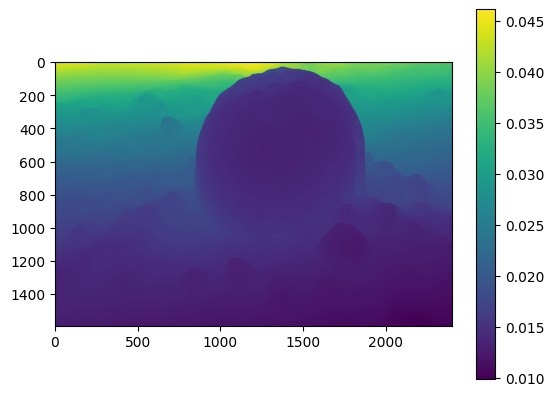

In [14]:
plt.imshow(Bg)
plt.colorbar()

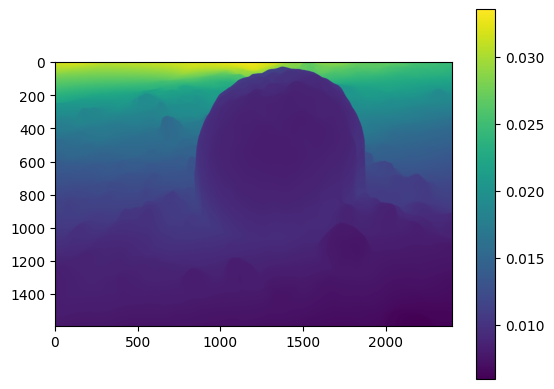

In [15]:
plt.imshow(Bb)
plt.colorbar()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.01333245602821308..0.9865304767965638].


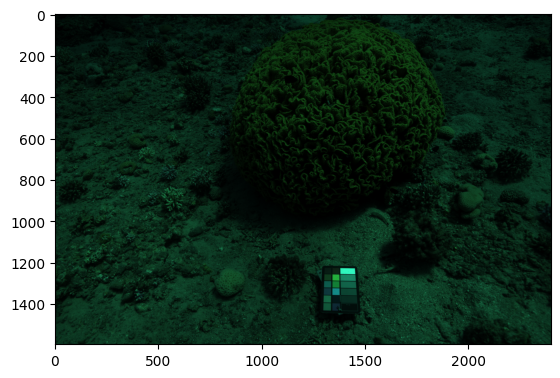

In [16]:

plt.imshow(img - backscatter)